In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

__________________________________________________________________________________________________________________________________________________________________________________________
#### EXOTIC SPECIES:
* Sus scrofa - feral pig
#### APEX PREDATOR:
* Aquila chrysaetos - golden eagle
#### ENDEMIC CARNIVORES:
* Urocyon littoralis - island fox
* Spilogale gracilis amphiala - island spotted skunk


"By acting as an abundant prey, pigs enabled native, mainland golden eagles to colonize the California Channel Islands, and through hyperpredation, indirectly caused a rapid decline in the native fox populations (15). This colonization event not only restructured the trophic hierarchy on the islands—eagles became the apex predator and both the fox and the skunk became prey—but it also altered the competitive relations between the fox and the skunk and caused a radical change in the carnivore community."
__________________________________________________________________________________________________________________________________________________________________________________________

### Field metabolic rates:
* Foxes:
    * males - 1,426.1 kJ/day
    * females - 1,310.2 kJ/day
* Skunks:
    * males - 527.0 kJ/day
    * females - 438.9 kJ/day

* Allometry
    * Fox:
        * male = 2.00 +- 0.23 kg, n = 77
        * female = 1.81 +- 0.22 kg, n = 77
    * Skunk: 
        * male = 620 +- 40 g, n = 5
        * female = 500 +- 40 g, n = 4


* Daily food consumption [gram of dry matter (DM) per day]
    * by using estimates of metabolizable energy:
        * for omnivores (14.0 kJ/g of DM)
        * for carnivores (16.8 kJ/g of DM)


* Fresh animal matter (FM) consumed:
    * 3.33 g FM = 1 g DM
        * by a pair of foxes - 500.58 g FM/day
        * by a pair of skunks - 181.58 g FM/day)
__________________________________________________________________________________________________________________________________________________________________________________________

### Relative index of animal food in the diet of:
* Fox - 0.77 animal and 0.23 plant
* Skunks - assumed completely carnivorous
__________________________________________________________________________________________________________________________________________________________________________________________
   

In [46]:
## Variables:

# E = golden eagle (predator)
E0 = 21 # placeholder

# F = fox (prey)
F0 = 1312

# S = skunk (prey)
S0 = 1000
# S0 = 700

# P = piglet (prey)
P0 = 13827

# r_i = instrinsic growth rate
r_f = 0.32
r_p = 0.78
r_s = r_f

# K_i = carrying capacity
K_f = 1544
K_s = 2490
K_p = 15189

# beta_ij = measure of energetic resource competition between foxes and skunks only
beta_sf = 500.48 / 181.58
beta_fs = 181.58 / 500.48

# mu_i = predation rate by eagles
    # Eagles kill ~132.1 prey per year or 0.34 foxes (or piglets) per day outside of the 70-day breeding season, and 0.45 during the breeding season
mu_f = 0.086
mu_p = 0.019
mu_s = 0.159

# phi = term of eagle preference for foxes
phi = 8.1

# sigma = term of eagle preference for skunks relative to piglets
    #  If phi or sigma is greater than 1, eagles prey more often on foxes or skunks than on piglets, respectively
sigma = 3.1

# nu = eagle mortality rate
nu = 0.09

# lambda_i = the rate at which prey i are turned into new predators
lambda_f = 7.7e-4
lambda_p = 7.7e-4
lambda_s = 2.5e-4

# tau = the time necessary for a pair of eagles to produce an adult eagle (comparable to a generation time of 5 years)

S_cap_max = np.array([1.8, ])
S_cap_min = np.array([0.2, ])
F_cap_max = np.array([37, ])
F_cap_min = np.array([19.6, ])
cap_year = np.array([1993, 1995, 1996, 1997, 1998, 1999])


In [23]:
# ## Differential Equations
dFdt = r_f * F * (1 - ((F + (beta_fs * S)) / K_f)) - mu_f * ((phi * F) / ((phi * F) + (sigma * S) + (P))) * E * F
dSdt = r_s * S * (1 - ((S + (beta_sf * F)) / K_s)) - mu_s * ((sigma * S) / ((phi * F) + (sigma * S) + (P))) * E * S
dPdt = r_p * P * (1 - (P / K_p)) - mu_p * (P / ((phi * F) + (sigma * S) + (P))) * E * P
dEdt = (((lambda_f * mu_f * phi * F) + (lambda_s * mu_s * sigma * (S**2)) + (lambda_p * mu_p * (P**2)) * E) / ((phi * F) + (sigma * S) + (P))) - (nu * E)


In [24]:
def derivative(X, t, phi, sigma, nu, r_f, r_s, r_p, K_f, K_s, K_p, mu_f, mu_s, mu_p, lambda_f, lambda_s, lambda_p, beta_fs, beta_sf):
    F, S, P, E = X
    dFdt = r_f * F * (1 - ((F + (beta_fs * S)) / K_f)) - mu_f * ((phi * F) / ((phi * F) + (sigma * S) + (P))) * E * F
    dSdt = r_s * S * (1 - ((S + (beta_sf * F)) / K_s)) - mu_s * ((sigma * S) / ((phi * F) + (sigma * S) + (P))) * E * S
    dPdt = r_p * P * (1 - (P / K_p)) - mu_p * (P / ((phi * F) + (sigma * S) + (P))) * E * P
    dEdt = (((lambda_f * mu_f * phi * F) + (lambda_s * mu_s * sigma * (S**2)) + (lambda_p * mu_p * (P**2)) * E) / ((phi * F) + (sigma * S) + (P))) - (nu * E)
    return np.array([dFdt, dSdt, dPdt, dEdt])

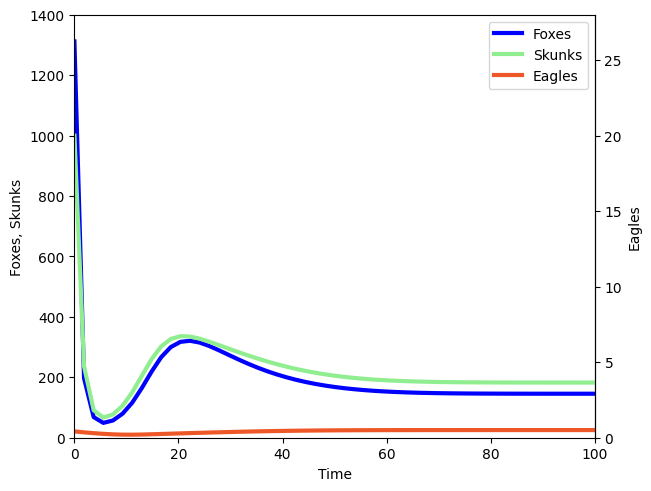

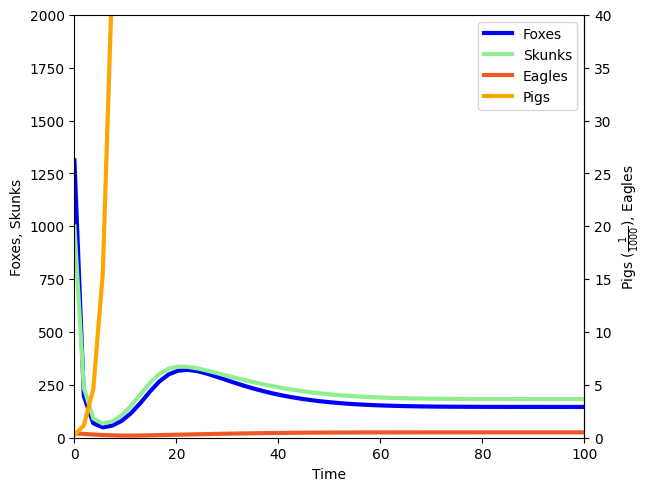

In [54]:
def deriv(state, t):
    # unpack state variables
    F, S, P, E = state

    # define system of equations
    dFdt = r_f * F * (1 - ((F + (beta_fs * S)) / K_f)) - mu_f * ((phi * F) / ((phi * F) + (sigma * S) + (P))) * E * F
    dSdt = r_s * S * (1 - ((S + (beta_sf * F)) / K_s)) - mu_s * ((sigma * S) / ((phi * F) + (sigma * S) + (P))) * E * S
    dPdt = r_p * P * (1 - (P / K_p)) - mu_p * (P / ((phi * F) + (sigma * S) + (P))) * E * P
    dEdt = (((lambda_f * mu_f * phi * F) + (lambda_s * mu_s * sigma * (S**2)) + (lambda_p * mu_p * (P**2)) * E) / ((phi * F) + (sigma * S) + (P))) - (nu * E)
    return np.array([dFdt, dSdt, dPdt, dEdt])


t = np.linspace(0, 100, 55)

state0 = [F0, S0, P0/1000, E0]

N = np.sum(state0)

state = odeint(deriv, state0, t)

F, S, P, E = state.T



def y1_y2(x):
    return ((2*x)/100)

def y2_y1(x):
    return x*50

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(t, F, '-', linewidth = 3, label = 'Foxes', color = 'blue')
ax.plot(t, S, '-', linewidth = 3, label = 'Skunks', color = 'lightgreen')
ax.plot(t, E, '-', linewidth = 3, label = 'Eagles', color = '#ee5727')
ax.set_xlabel('Time')
ax.set_ylabel('Foxes, Skunks')
secax = ax.secondary_yaxis('right', functions = (y1_y2, y2_y1))
secax.set_ylabel('Eagles')
secax.set_ylim(0, 30)
plt.xlim(0, 100)
plt.ylim(0, 1400)
plt.legend()
plt.show()



fig, ax = plt.subplots(constrained_layout=True)
ax.plot(t, F, '-', linewidth = 3, label = 'Foxes', color = 'blue')
ax.plot(t, S, '-', linewidth = 3, label = 'Skunks', color = 'lightgreen')
ax.plot(t, E, '-', linewidth = 3, label = 'Eagles', color = '#ee5727')
ax.plot(t, P, '-', linewidth = 3, label = 'Pigs', color = 'orange')
ax.set_xlabel('Time')
ax.set_ylabel('Foxes, Skunks')
secax = ax.secondary_yaxis('right', functions = (y1_y2, y2_y1))
secax.set_ylabel(r'Pigs ($\frac{1}{1000}$), Eagles')
secax.set_ylim(0, 30)
plt.xlim(0, 100)
plt.ylim(0, 2000)
plt.legend()
plt.show()

